# Machine Failure Prediction using Machine Learning
Author: Chen ZhuoFan (P2100746) | Singapore Polytechnic

Globalisation is the process of interaction and integration among people,companies and governments worldwide.It has accelerated since the 18th century and have enabled the trade of goods and services at a bigger scale.

The production of goods need to be done more effectively.In today's world, many goods are manufacturing by machines in a pipeline to ensure high efficiency and precision at the same time. However,machines may malfunction with time.These malfunctioning machines may result in defects in goods which is not favourable. Manual checking can be time-consuming and cost-inefficient.

Machine Learning is defined by Mitchell (1997) as the study of computer algorithms that improve automatically through experience. [3] Machine learning comes to our sight in the recent decades with its ease and high performance. It has the capacity to learn and identify patterns from data and make decision.

In this experiment ,we will make use of machine learning model to assist us in predicting malfunctioning machines so that repairs or replacements can be done in time to reduce disruption and loss.


## Problem Statement

How can we make use of machine learning to predict malfunctioning machines in the factories?

## Importing Libraries

In [1]:
!pip install numpy matplotlib pandas seaborn scikit-learn==1.0.2 yellowbrick phik statsmodels pyampute xgboost imblearn missingno mlxtend --user 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")



# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, plot_precision_recall_curve, plot_roc_curve, confusion_matrix
from yellowbrick.model_selection import learning_curve

# Missing Value
from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.impute import KNNImputer



# Data Preprocessing
import phik
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import  OneHotEncoder,QuantileTransformer
from sklearn.preprocessing import  MinMaxScaler


# Models
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb


# Feature Importance
from sklearn.inspection import permutation_importance

# Hyperparameter Tuning
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import recall_score

# Feature Selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel, RFE, SelectKBest,chi2

import joblib
# Random State
random_state = 0

In [3]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

## Data Ingestion

In [4]:
machineDf=pd.read_csv("./factory_data (classification).csv",index_col='Unique ID')
machineDf

,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
Unique ID,,,,,,,,
1,K12965,M,24.95,35.45,1551.0,42.8,0,0
2,Z62710,L,25.05,35.55,1408.0,46.3,3,0
3,T20224,L,24.95,35.35,1498.0,49.4,5,0
4,Z33024,L,25.05,35.45,1433.0,39.5,7,0
5,Z52839,L,25.05,35.55,1408.0,40.0,9,0
...,...,...,...,...,...,...,...,...
19996,T87335,M,25.75,35.35,NaN,29.5,14,0
19997,Z59525,H,25.85,35.35,1632.0,31.8,17,0
19998,T83921,M,25.95,NaN,NaN,33.4,22,0


## Data Exploration

### Data Structure

In [5]:
machineDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 20000
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Product ID            20000 non-null  object 
 1   Quality               19009 non-null  object 
 2   Ambient T (C)         20000 non-null  float64
 3   Process T (C)         19600 non-null  float64
 4   Rotation Speed (rpm)  18812 non-null  float64
 5   Torque (Nm)           20000 non-null  float64
 6   Tool Wear (min)       20000 non-null  int64  
 7   Machine Status        20000 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 1.4+ MB


### Managing Missing Data

In [6]:
pd.DataFrame(machineDf.isna().sum().sort_values(ascending=False))

,0
Rotation Speed (rpm),1188
Quality,991
Process T (C),400
Product ID,0
Ambient T (C),0
Torque (Nm),0
Tool Wear (min),0
Machine Status,0


In [7]:
machineDf[machineDf.isnull().any(axis=1)]

,Product ID,Quality,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
Unique ID,,,,,,,,
7,K40563,L,24.95,NaN,NaN,42.4,14,0
11,K30974,NaN,25.25,35.75,1782.0,23.9,24,0
15,T39889,NaN,25.45,36.05,2035.0,19.6,40,0
20,T81915,M,25.75,NaN,1632.0,32.5,55,0
21,S64787,H,25.75,36.15,NaN,42.7,58,0
...,...,...,...,...,...,...,...,...
19982,Z53954,L,25.65,NaN,1353.0,47.0,190,0
19987,S13645,M,25.75,35.55,NaN,42.3,207,0
19992,T72209,M,25.85,35.35,NaN,26.1,5,0


<AxesSubplot:title={'center':'Number of missing value in features'}>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


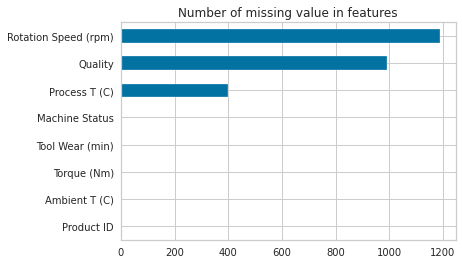

In [8]:
machineDf.isna().sum().sort_values().plot.barh(title='Number of missing value in features')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


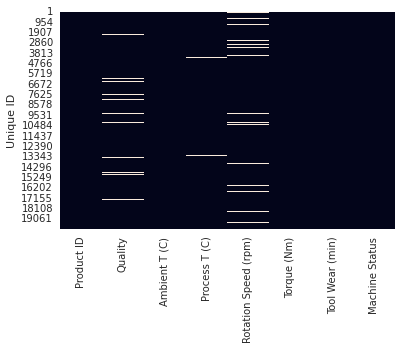

In [9]:
import seaborn as sns
sns.heatmap(machineDf.isnull(), cbar=False)
plt.show()

<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


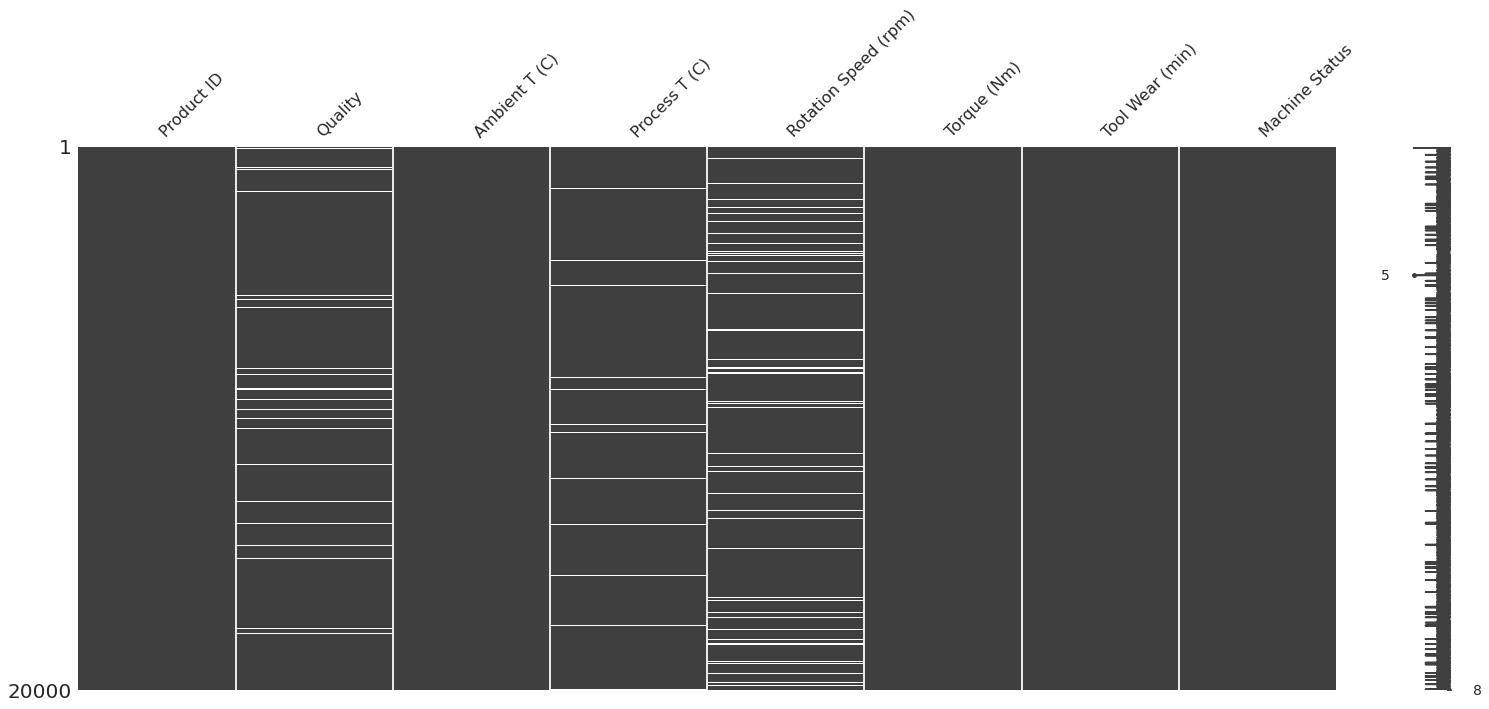

In [10]:
import missingno as msno
msno.matrix(machineDf)

<AxesSubplot:>

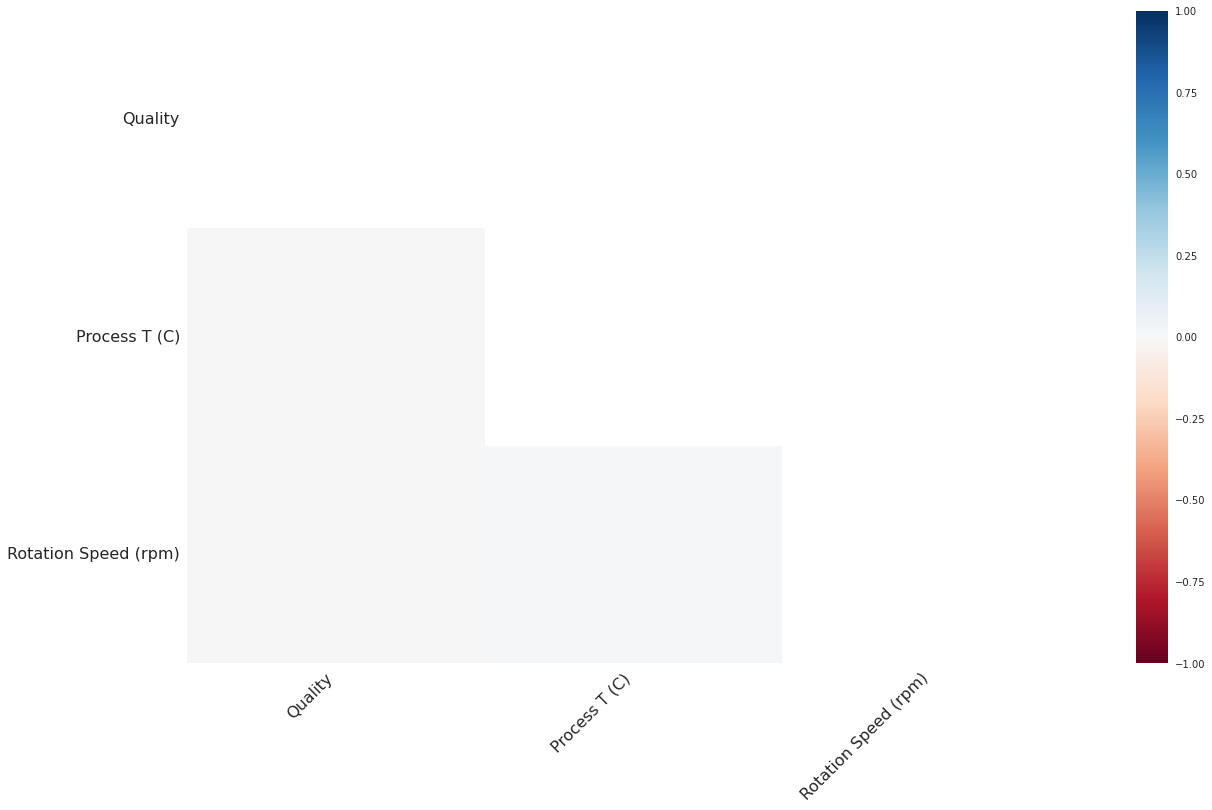

In [11]:
msno.heatmap(machineDf)

### Target Label

Text(0.5, 1.0, 'Distribution of target label')

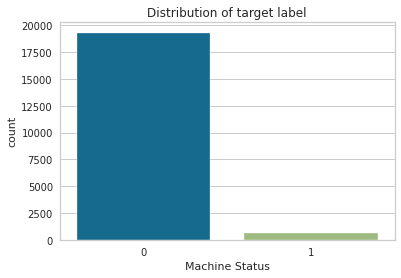

In [12]:
sns.countplot(data=machineDf,x='Machine Status').set_title("Distribution of target label")

### Qualitative Features

In [13]:
qualitativeVariable=['Product ID', 'Quality']

### Qualitative Features

In [14]:
quantitativeVariable=['Ambient T (C)', 'Process T (C)',
       'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)']

### Univariate Analysis

In [15]:
machineDf[quantitativeVariable].describe()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min)
count,20000.000000,19600.000000,18812.000000,20000.000000,20000.000000
mean,26.904930,36.904291,1538.795397,39.986910,107.951000
std,2.000834,1.483647,178.674963,9.968684,63.652555
min,22.150000,32.550000,1168.000000,3.800000,0.000000
25%,25.250000,35.750000,1423.000000,33.200000,53.000000
50%,26.950000,36.950000,1503.000000,40.100000,108.000000
75%,28.450000,37.950000,1613.000000,46.800000,162.000000
max,31.450000,40.750000,2886.000000,76.600000,253.000000


In [16]:
descriptive_stats = machineDf.astype('category').describe().T
descriptive_stats["Proportion of Most Frequent Value"] = descriptive_stats["freq"] / len(machineDf.astype('category')) * 100
descriptive_stats.sort_values("Proportion of Most Frequent Value", ascending=False)

,count,unique,top,freq,Proportion of Most Frequent Value
Machine Status,20000,2,0,19322,96.61
Quality,19009,3,L,11390,56.95
Process T (C),19600.0,83.0,37.45,575.0,2.875
Ambient T (C),20000.0,94.0,27.55,495.0,2.475
Tool Wear (min),20000,246,0,240,1.2
Torque (Nm),20000.0,577.0,40.2,104.0,0.52
Rotation Speed (rpm),18812.0,941.0,1452.0,93.0,0.465
Product ID,20000,19408,K34631,3,0.015


<AxesSubplot:xlabel='Quality', ylabel='count'>

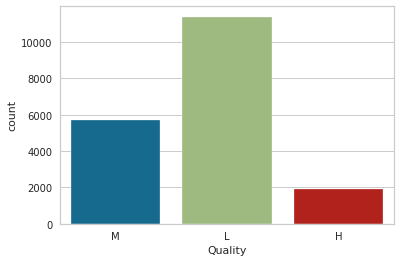

In [17]:
sns.countplot(x='Quality',data=machineDf,)

array([[<AxesSubplot:title={'center':'Ambient T (C)'}>,
        <AxesSubplot:title={'center':'Process T (C)'}>],
       [<AxesSubplot:title={'center':'Rotation Speed (rpm)'}>,
        <AxesSubplot:title={'center':'Torque (Nm)'}>],
       [<AxesSubplot:title={'center':'Tool Wear (min)'}>, <AxesSubplot:>]],
      dtype=object)

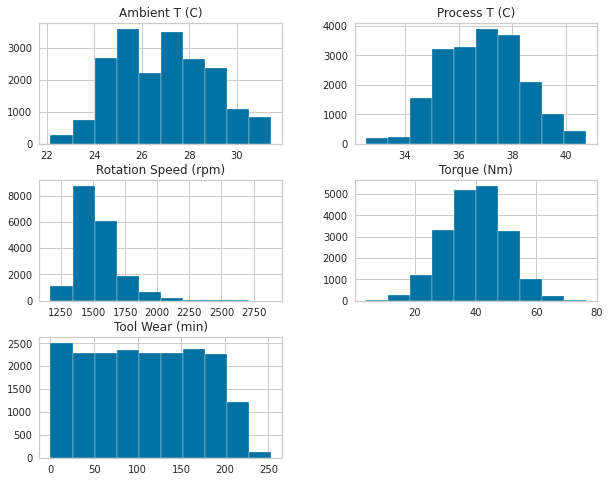

In [18]:
machineDf[quantitativeVariable].hist(figsize=(10,8))

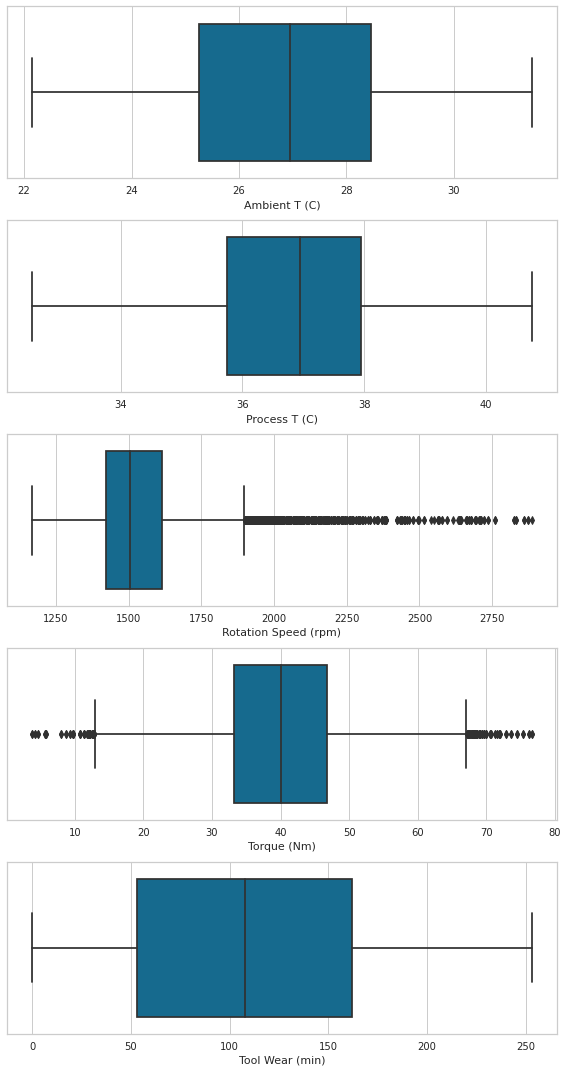

In [19]:
fig, ax = plt.subplots(len(quantitativeVariable), 1, figsize=(8, 15), tight_layout=True)
for idx, feature in enumerate(quantitativeVariable):
    sns.boxplot(data=machineDf, x=feature, ax = ax[idx])
fig.show()

In [20]:
Q1 = machineDf['Rotation Speed (rpm)'].quantile(0.25)
Q3 = machineDf['Rotation Speed (rpm)'].quantile(0.75)
IQR = Q3 - Q1
machineDf[machineDf['Rotation Speed (rpm)'] >Q3 + 1.5 * IQR].describe()

,Ambient T (C),Process T (C),Rotation Speed (rpm),Torque (Nm),Tool Wear (min),Machine Status
count,771.000000,757.000000,771.000000,771.000000,771.000000,771.000000
mean,27.163230,37.031242,2103.333333,18.846174,107.712062,0.084306
std,2.062808,1.507887,216.956317,3.588364,65.390417,0.278027
min,22.450000,32.850000,1899.000000,3.800000,0.000000,0.000000
25%,25.350000,35.950000,1950.500000,16.800000,45.000000,0.000000
50%,27.450000,37.250000,2016.000000,19.700000,110.000000,0.000000
75%,28.750000,38.050000,2182.000000,21.500000,165.000000,0.000000
max,31.250000,40.650000,2886.000000,25.000000,244.000000,1.000000


Text(0.5, 1.0, 'Relationship between Torque and Rotation Speed')

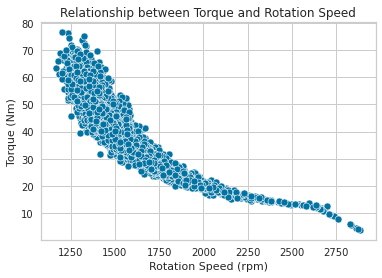

In [21]:
sns.scatterplot(x='Rotation Speed (rpm)',y='Torque (Nm)',data=machineDf).set_title('Relationship between Torque and Rotation Speed')

### Bivariate Analysis

In [22]:
# fig, ax = plt.subplots(len(quantitativeVariable), 1, figsize=(8, 15), tight_layout=True)
# for idx, feature in enumerate(quantitativeVariable):

#     sns.histplot(data=machineDf,common_norm = False,stat='density', x=feature, hue="Machine Status",ax=ax[idx],kde=True)
# fig.show()

In [23]:

# sns.histplot(data=machineDf,common_norm = False,stat='density', x='Quality', hue="Machine Status")


<AxesSubplot:xlabel='Quality', ylabel='count'>

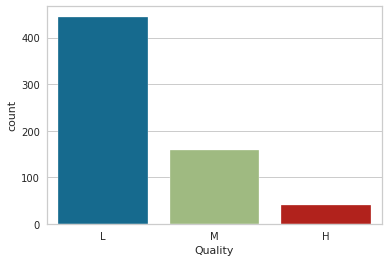

In [24]:
sns.countplot(data=machineDf[machineDf['Machine Status']>0],x='Quality')

In [25]:
# sns.pairplot(machineDf, hue="Machine Status")

interval columns not set, guessing: ['Ambient T (C)', 'Process T (C)', 'Rotation Speed (rpm)', 'Torque (Nm)', 'Tool Wear (min)', 'Machine Status']


/home/chzuofa/.local/lib/python3.8/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable Product ID is large: 19408. Are you sure this is not an interval variable? Analysis for pairs of variables including Product ID can be slow.
  warnings.warn(


Text(0.5, 1.0, 'Correlation Matrix')

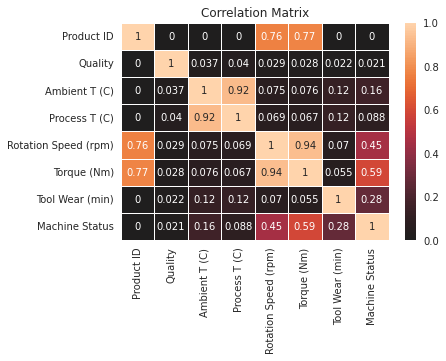

In [26]:
corr_matrix = machineDf.phik_matrix()

sns.heatmap(corr_matrix, annot = True, linewidths=.5,center = 0).set_title('Correlation Matrix')

In [27]:
machineDf=machineDf.drop(['Product ID','Rotation Speed (rpm)'],axis=1)

## Data-Processing

### Missing data imputation

## Training and testing data

In [28]:
x_train, x_test, y_train, y_test = train_test_split(machineDf. loc[:, machineDf. columns != 'Machine Status'],machineDf['Machine Status'], random_state = 42, stratify=machineDf['Machine Status'], test_size = .20)
x_train

,Quality,Ambient T (C),Process T (C),Torque (Nm),Tool Wear (min)
Unique ID,,,,,
12792,H,27.35,36.55,43.3,66
6583,L,28.35,37.35,35.7,198
16874,L,27.95,38.35,39.5,75
11392,L,25.85,37.15,8.8,142
4411,L,29.35,37.05,32.2,64
...,...,...,...,...,...
5303,L,30.75,39.95,37.2,195
15452,L,29.95,39.65,48.8,120
18260,L,26.05,37.45,38.4,146


In [29]:
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTENC, SMOTE

## Feature Scaling

In [30]:
quantitativeVariable=['Ambient T (C)', 'Process T (C)', 'Torque (Nm)', 'Tool Wear (min)']


quantitativeTransformer=Pipeline([
     ('Normaliser',MinMaxScaler())
])
categorical_transformers = Pipeline([
    ('One Hot Encoder', OneHotEncoder(handle_unknown='ignore'))
])
data_preprocessing = ColumnTransformer([
    ('Preprocess Numerical Features', quantitativeTransformer, [0,1,2,3]),
       ('Preprocess Categorical Features', categorical_transformers, [4])
])

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin


class ColumnSelector(BaseEstimator, TransformerMixin):

    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        """ Get either categorical or numerical columns on fit.
        Store as attribute for future reference"""
        X = X if isinstance(X, pd.DataFrame) else pd.DataFrame(X)
        if self.dtype == 'numerical':
            self.cols = X.select_dtypes(exclude='O').columns.tolist()
        elif self.dtype == 'categorical':
            self.cols = X.select_dtypes(include='O').columns.tolist()
        self.col_idx = [machineDf.columns.get_loc(col) for col in self.cols]
        return self

    def transform(self, X):
        """ Subset columns of chosen data type and return np.array"""
        X = X.values if isinstance(X, pd.DataFrame) else X
        return X[:, self.col_idx]

In [32]:
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
categorical = ['Quality']
numerical = ['Ambient T (C)', 'Process T (C)', 'Torque (Nm)', 'Tool Wear (min)']



num_imp=Pipeline([
 ('num_selector', ColumnSelector('numerical')),
 ('Imputation',IterativeImputer(estimator=RandomForestRegressor(n_jobs=-1),
                           initial_strategy='mean',
                           max_iter=3,skip_complete=True ,random_state=0)),
])

cat_imp=Pipeline([
     ('cat_selector', ColumnSelector('categorical')),
     ('One Hot Encoder1', OrdinalEncoder ()),
     ('Imputation',IterativeImputer(estimator=RandomForestClassifier(n_jobs=-1),
                           initial_strategy='most_frequent',
                           max_iter=3,skip_complete=True,random_state=0)),
])


preproc = FeatureUnion([
    ('num_pipe', num_imp),
    ('cat_pipe', cat_imp)
])

### Oversampling :SMOTE NC

In [33]:
from imblearn.pipeline import Pipeline as imbpipeline
colselect=[col in qualitativeVariable for col in machineDf. loc[:, machineDf. columns != 'Machine Status'].columns]

colselect.reverse()


In [34]:
class DfConverter():
    def __init__(self):
        super().__init__()

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

    def transform(self, X, y=None):
        df = pd.DataFrame(X)     
        return df

    def fit(self, X, y=None):
        return self


In [35]:
class customSelector():
    def __init__(self):
        super().__init__()

    def fit_transform(self, X, y=None):
        return self.transform(X=X, y=y)

    def transform(self, X, y=None):
        return pd.DataFrame(X)[[0,1,2,3,4,5,6]]

    def fit(self, X, y=None):
        return self

## Feature Selection

In [36]:
# selectionRecord=pd.DataFrame({'no':[],'score':[]})
# for i in range(1,8):
#     Final = imbpipeline([
#     ('Imputation',preproc),
#     ('DF Converter',DfConverter()),
#     ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
#     ('DF Converter1',DfConverter()),
#     ('Data Preprocessing', data_preprocessing),
#     ('Kbest',SelectKBest(chi2,k=i)),
#     ('Model',   xgb.XGBClassifier())
# ])
#     selectionRecord=pd.concat([selectionRecord,pd.DataFrame({'no':[i],'score':[cross_validate(Final,x_train,y_train,cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0,),scoring=['recall'],n_jobs=-1,return_estimator=True,return_train_score=True)['test_recall'].mean()]})],ignore_index=True)


# sns.lineplot(x='no',y='score',data=selectionRecord).set_title('Number of feature selected')

## Evaluation Methodology

In [37]:
def scoreModel(clf,x,y,algName=None,record=pd.DataFrame({'name':[],'train_accuracy':[],'test_accuracy':[],'test_recall':[],'train_recall':[]})):
    '''
    This function is used for model evaluation . This function use scikit-learn library to carry out cross validation using StratifiedKFold. The scoring metrics are accuracy and balanced accuracy

    :param clf: Classifier 分类器
    :param x:Train Data X(Data)  训练数据 （数据）
    :param y:Train Data Y(Result)  训练数据（结果）
    :param algName: Name of Algorithm used for recording 算法名字
    :param record: History record dataframe 在历史记录上叠加结果
    :return:
    This function return 3 variable: 这个函数返回三个参数
    record: Dataframe with current and past record(if there is any)
    current: Dataframe with current record
    lr: Learning curve
    '''
    score=cross_validate(clf,x,y,cv=StratifiedKFold(n_splits = 5,shuffle = True, random_state = 0),scoring=['accuracy','recall'],n_jobs=-1,return_estimator=True,return_train_score=True)
    current=pd.DataFrame({'name':[algName],'train_accuracy':score['train_accuracy'].mean(),'test_accuracy':score['test_accuracy'].mean(),'test_recall':score['test_recall'].mean(),'train_recall':score['train_recall'].mean()})
    record=pd.concat([record,current],ignore_index=True)
    lr = learning_curve(clf, x, y, scoring = 'recall', cv = StratifiedKFold(n_splits = 5,shuffle = True, random_state = 0), n_jobs=-1)
    return record,current,lr

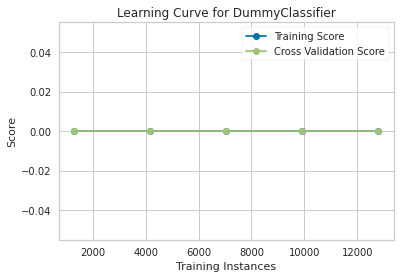

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Dummy Baseline Classifier,0.966125,0.966125,0.0,0.0


In [38]:

from imblearn.over_sampling import SMOTENC
baseline = imbpipeline([

('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),
    ('Model', DummyClassifier())
])
record,current,lr=scoreModel(baseline,x_train,y_train,"Dummy Baseline Classifier")
current

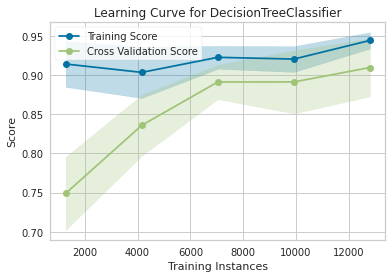

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Decision Tree Classifier,0.879125,0.873938,0.898607,0.945572


In [39]:

DeciTree = imbpipeline([
('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),
    ('model', DecisionTreeClassifier(max_depth=9,ccp_alpha=0.000224,max_leaf_nodes=13))
])


record,current,lr=scoreModel(DeciTree,x_train,y_train,"Decision Tree Classifier",record=record)
current

In [40]:
# parameter={'model__max_depth':np.arange(1,10),'model__ccp_alpha':np.arange(0.00827,0.05,0.01)}
# pd.DataFrame(GridSearchCV(DeciTree,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)


In [41]:


# from sklearn.model_selection import validation_curve
# pr=np.arange(5,20,1)
# train_score,test_score = validation_curve(DeciTree,x_train,y_train,param_name='model__max_depth',param_range=pr,cv=StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0,),scoring='recall')
# train_score =  np.mean(train_score,axis=1)
# test_score = np.mean(test_score,axis=1)
# plt.plot(pr,train_score,'o-',color = 'r',label = 'training')
# plt.plot(pr,test_score,'o-',color = 'g',label = 'testing')
# plt.legend(loc='best')
# plt.xlabel('number of tree')
# plt.ylabel('accuracy')
# plt.show()



In [42]:
# test_score

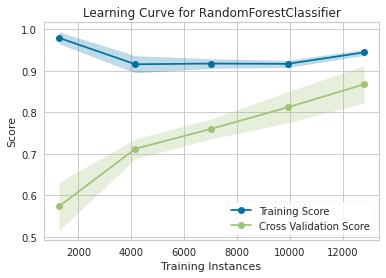

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Random Forest Classifier,0.934688,0.926125,0.867125,0.942808


In [43]:
randomFor = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),
    ('model', RandomForestClassifier(max_depth=9,ccp_alpha=0.000224,n_estimators=20,n_jobs=-1))
])
# parameter={'model__max_depth':np.arange(1,9),'model__ccp_alpha':np.arange(0.00827,0.03,0.001)}
# pd.DataFrame(GridSearchCV(randomFor,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)

record,current,lr=scoreModel(randomFor,x_train,y_train,"Random Forest Classifier",record=record)
current

In [44]:
# parameter={'model__max_depth':np.arange(1,10),'model__ccp_alpha':np.arange(0.00827,0.05,0.01)}
# pd.DataFrame(GridSearchCV(randomFor,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)


/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeIm

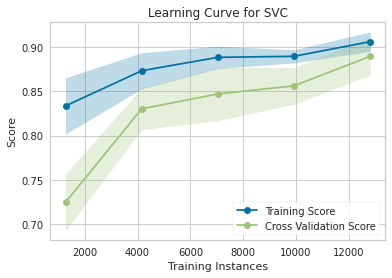

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,SVM Classifier,0.894484,0.894438,0.887428,0.900827


In [45]:
svm = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),
    ('model', SVC(gamma=0.5,C=6))
])
# parameters = {'model__kernel':('linear', 'rbf'), 'model__C':np.arange(1,10),}
# pd.DataFrame(GridSearchCV(svm,param_grid=parameters,scoring='recall',n_jobs=-1).fit(x_train,y_train).cv_results_)

record,current,lr=scoreModel(svm,x_train,y_train,"SVM Classifier",record=record)
current

In [46]:
# parameter={'model__C':np.arange(1,10),'model__gamma':np.arange(0.1,1,0.1)}
# pd.DataFrame(GridSearchCV(svm,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)

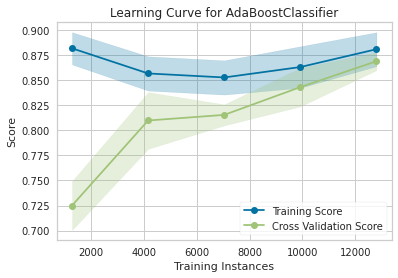

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Adaptive Boosting Classifier,0.910922,0.9085,0.848675,0.872228


In [47]:
lgbmC = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),

    ('model', AdaBoostClassifier())
])


# parameter={'model__n_estimators':np.arange(1,13),'model__learning_rate':np.arange(0.1,2,0.01)}
#
# pd.DataFrame(GridSearchCV(lgbmC,param_grid=parameter,scoring='recall',n_jobs=-1).fit(x_train,y_train).cv_results_)

record,current,lr=scoreModel(lgbmC,x_train,y_train,"Adaptive Boosting Classifier",record=record)
current

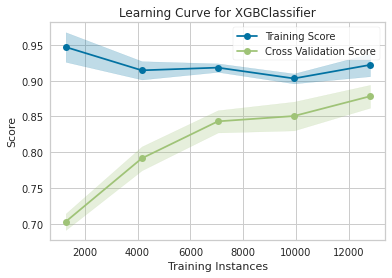

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,eXtreme Gradient Boosting Classifier,0.928719,0.924375,0.870897,0.926203


In [48]:

xgboost = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),

    ('Model', xgb.XGBClassifier(tree_method='hist',max_depth=2))
])
record,current,lr=scoreModel(xgboost,x_train,y_train,"eXtreme Gradient Boosting Classifier",record)
current

In [49]:
# parameter={'Model__max_depth':np.arange(1,10),'Model__n_estimators':np.arange(1,16)}
# pd.DataFrame(GridSearchCV(xgboost,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)


/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/chzuofa/.local/lib/python3.8/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeIm

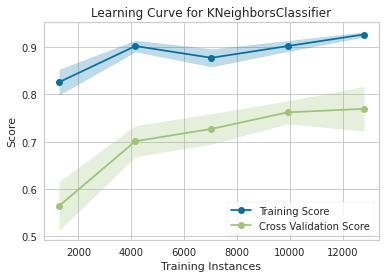

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,K-Nearest Neighbour Classifier,0.965437,0.949062,0.776622,0.925738


In [50]:
knnClassifier = imbpipeline([
    ('Imputation',preproc),
    ('DF Converter',DfConverter()),
    ('SMOTE NC Oversampling',SMOTENC(categorical_features=colselect,n_jobs=-1)),
    ('DF Converter1',DfConverter()),
    ('Data Preprocessing', data_preprocessing),
    ('Model', KNeighborsClassifier(n_neighbors=6))
])
record,current,lr=scoreModel(knnClassifier,x_train,y_train,"K-Nearest Neighbour Classifier",record=record)
current

In [51]:
# parameter={'Model__n_neighbors':np.arange(1,20)}
# pd.DataFrame(GridSearchCV(knnClassifier,param_grid=parameter,scoring='recall').fit(x_train,y_train).cv_results_)


In [52]:
record

,name,train_accuracy,test_accuracy,test_recall,train_recall
0,Dummy Baseline Classifier,0.966125,0.966125,0.000000,0.000000
1,Decision Tree Classifier,0.879125,0.873938,0.898607,0.945572
2,Random Forest Classifier,0.934688,0.926125,0.867125,0.942808
3,SVM Classifier,0.894484,0.894438,0.887428,0.900827
4,Adaptive Boosting Classifier,0.910922,0.908500,0.848675,0.872228
5,eXtreme Gradient Boosting Classifier,0.928719,0.924375,0.870897,0.926203
6,K-Nearest Neighbour Classifier,0.965437,0.949062,0.776622,0.925738
